## Example 10.4: Direct inversion of the matrix and the full evolution

Use direct inversion of the tri-diagonal matrix to calculate the evolution in the problem of Examples 10.3 and 10.4. 

(a) Use the implicit formula as the starting point: 

$\phi^{n+1} = \frac{1}{1 + \hat{H} \Delta t} \left[ \phi^n + S^n \Delta t \right]$,

with: 

$(\hat{H}\phi)_i = -\frac{\phi_{i+1} + \phi_{i-1} - 2 \phi_i}{h^2}$.

(b) Use the *full* evolution formula:

$\phi^n = e^{-n \Delta t \hat{H}} \phi^0$,

in the form:

$\phi^{n+1} = e^{-\Delta t \hat{H}} \phi^n$.

You may use the matrix SciPy exponential: 

```scipy.linalg.expm```



In [6]:
import numpy as np
import scipy

# Define the initial function:
def phiInitialfunc(x):
    """The initial function"""
    return np.exp(-20 * (x-0.5)**2) - np.exp(-20*(x-3/2)**2) - np.exp(-20*(x+1/2)**2)

# define the S function:
def Sfunc(x,t):
    """The S function for the parabolic PDE"""
    return 0.

# define the exact solution:
def phiExact(x,t):
    """Returns the exact solution of the problem"""
    tau = 1 + 80 * t
    phiex = tau**(-0.5) * ( np.exp(-20 * (x-0.5)**2/tau) - np.exp(-20 * (x-1.5)**2/tau) - np.exp(-20*(x+0.5)**2/tau))
    return phiex

# function that calculates the inverse of 1 + H Deltat,
# corresponding to the evolution operator in the implicit scheme
def EvolutionOperator(N, Deltat):
    """Function that calculates the inverse of 1 + H Deltat"""
    # calculate the spacing between lattice points
    h = 1/N
    # first construct the H matrix.
    # this is an (N+1)x(N+1) matrix, for N+1 lattice points
    H = np.zeros((N+1, N+1)) # start with all zeros
    # elements (1, -2, 1):
    el = [1, -2, 1]
    # fill H row-by-row:
    for i in range(1,N): 
        for j in range(3):
            H[i][j+i-1] = el[j]
    # now multiply by - Deltat/h**2 and add 1:
    H = np.multiply(H, -Deltat/h**2)
    M = np.add(H,np.identity(N+1))
    # get the inverse:
    Minv = np.linalg.inv(M)
    return Minv

# function that calculates the full matrix operator exp(-Deltat H),
def EvolutionOperatorFull(N, Deltat):
    """Function that calculates the full matrix operator exp(-Deltat H)"""
    # calculate the spacing between lattice points
    h = 1/N
    # first construct the H matrix.
    # this is an (N+1)x(N+1) matrix, for N+1 lattice points
    H = np.zeros((N+1, N+1)) # start with all zeros
    # elements (1, -2, 1):
    el = [1, -2, 1]
    # fill H row-by-row:
    for i in range(1,N): 
        for j in range(3):
            H[i][j+i-1] = el[j]
    # now multiply by - Deltat/h**2 and add 1:
    H = np.multiply(H, -Deltat/h**2)
    EvoOp = scipy.linalg.expm(-H)
    return EvoOp 

# function that calculates the direct evolution via the inverse matrix (1 + H Delta t):
def EvolutionDirect(phiInitial, S, Deltat, tmin, tmax, N):
    """Calculate the time evolution by matrix inversion"""
    # calculate the spacing between lattice points
    h = 1/N
    # calculate the number of time steps:
    nt = int((tmax-tmin)/Deltat)
    # discretize the initial function on the lattice:  
    x = np.linspace(0,1,N+1)
    phii = phiInitial(x)
    # list of numpy arrays to hold the time-stepped lattices
    phi = [phii] # start with the initial condition
    # calculate the inverse matrix (1+H Deltat)
    Minv = EvolutionOperator(N, Deltat)
    # loop over time:
    for ti in range(nt):
        phinp1 = np.dot(Minv,phi[ti])
        phi.append(phinp1)
    return phi


# function that calculates the direct evolution via the inverse matrix (1 + H Delta t):
def EvolutionDirectFull(phiInitial, S, Deltat, tmin, tmax, N):
    """Calculate the time evolution by matrix inversion"""
    # calculate the spacing between lattice points
    h = 1/N
    # calculate the number of time steps:
    nt = int((tmax-tmin)/Deltat)
    # discretize the initial function on the lattice:  
    x = np.linspace(0,1,N+1)
    phii = phiInitial(x)
    # list of numpy arrays to hold the time-stepped lattices
    phi = [phii] # start with the initial condition
    # calculate the inverse matrix (1+H Deltat)
    EvoOp = EvolutionOperatorFull(N, Deltat)
    # loop over time:
    for ti in range(nt):
        phinp1 = np.dot(EvoOp,phi[ti])
        phi.append(phinp1)
    return phi

In [9]:
import timeit

# Run: 
Deltat = 0.005
tmin = 0
tmax = 0.045
N = 25

# direct evolution:
phiSol = EvolutionDirect(phiInitialfunc, Sfunc, Deltat, tmin, tmax, N)

# use the full evolution: 
phiSol2 = EvolutionDirectFull(phiInitialfunc, Sfunc, Deltat, tmin, tmax, N)

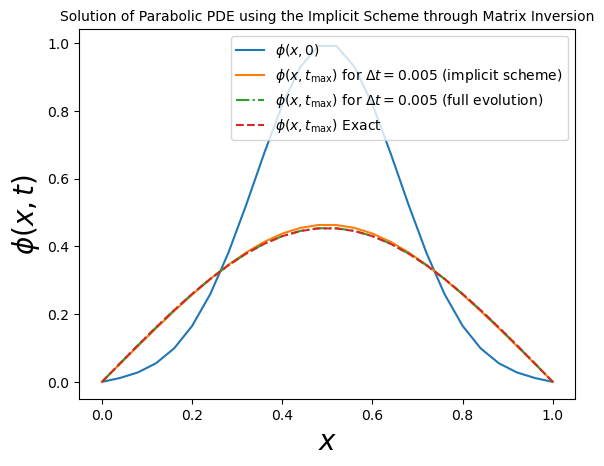

In [10]:
# Plot the solution: 
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$x$', fontsize=20) # set the x label
ax.set_ylabel(r'$\phi(x,t)$', fontsize=20) # set the y label. Note that the 'r' is necessary to remove the need for double slashes. You can use LaTeX! 
ax.set_title('Solution of Parabolic PDE using the Implicit Scheme through Matrix Inversion', fontsize=10) # set the title 

# make a one-dimensional plot using the above arrays, add a custom label
x = np.linspace(0,1,N+1)
ax.plot(x, phiSol[0], label=r'$\phi(x,0)$') 
ax.plot(x, phiSol[-1], label=r'$\phi(x,t_\mathrm{max})$ for $\Delta t=0.005$ (implicit scheme)', ls='-') 
ax.plot(x, phiSol2[-1], label=r'$\phi(x,t_\mathrm{max})$ for $\Delta t=0.005$ (full evolution)', ls='-.') 
ax.plot(x, phiExact(x,0.045), label=r'$\phi(x,t_\mathrm{max})$ Exact', ls='--') 

# construct the legend:
ax.legend(loc='upper right',fontsize=10)  # Add a legend

plt.show() # show the plot here